In [43]:
import fastf1
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import sklearn 
import time 

In [44]:
df = pd.read_csv('data/f1_data_Japanese_Grand_Prix_2025.csv')
df.head()

,Driver,LapTime_FP1,Compound_FP1,SpeedST_FP1,SpeedFL_FP1,SpeedI1_FP1,SpeedI2_FP1,LongestStintCompound_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,...,Q2_Pressure,Q3_TopSpeedST,Q3_AirTemp,Q3_TrackTemp,Q3_WindSpeed,Q3_WindDirection,Q3_Humidity,Q3_Pressure,TotalRaceTime,RacePosition
0,ALB,0 days 00:01:29.392000,SOFT,305.0,274.0,278.0,307.0,MEDIUM,7.0,0 days 00:01:34.412250,...,1013.3,294.0,14.4,28.7,3.6,149.0,60.0,1013.2,0 days 00:00:40.367000,9.0
1,ALO,0 days 00:01:29.222000,SOFT,302.0,271.0,275.0,304.0,HARD,7.0,0 days 00:01:31.104000,...,1013.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:57.333000,11.0
2,ANT,0 days 00:01:29.284000,SOFT,303.0,271.0,280.0,307.0,MEDIUM,13.0,0 days 00:01:34.429888888,...,1013.3,295.0,14.3,28.8,3.4,155.0,60.0,1013.3,0 days 00:00:18.671000,6.0
3,BEA,0 days 00:01:30.077000,SOFT,301.0,267.0,278.0,301.0,MEDIUM,9.0,0 days 00:01:32.337500,...,1013.3,294.0,14.3,28.8,3.4,155.0,60.0,1013.3,0 days 00:00:54.529000,10.0
4,BOR,0 days 00:01:30.147000,SOFT,300.0,268.0,277.0,305.0,HARD,13.0,0 days 00:01:34.285300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:01:23.897000,19.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Columns: 103 entries, Driver to RacePosition
dtypes: float64(86), object(17)
memory usage: 17.0+ KB


TotalRaceTime column works as follows: the driver that won the GP has the total race time written, for other drivers we have written the time delta to the race winner, also time not given if more than 1 lap behind leader 

1. rewrite total race time -> change it to seconds + actually write the whole time 
2. for all lap times -> rewrite them as seconds
3. rewrite compound as categorical variable -> soft 1, medium 2, hard 3
4. for spped just difference from slowest 

In [46]:
# for every lap time data 
df["LapTime_FP1"] = pd.to_timedelta(df["LapTime_FP1"]).dt.total_seconds()
df["LapTime_FP2"] = pd.to_timedelta(df["LapTime_FP2"]).dt.total_seconds()
df["LapTime_FP3"] = pd.to_timedelta(df["LapTime_FP3"]).dt.total_seconds()
df["AvgLapTime_LongestStint_FP1"] = pd.to_timedelta(df["AvgLapTime_LongestStint_FP1"]).dt.total_seconds()
df["AvgLapTime_LongestStint_FP2"] = pd.to_timedelta(df["AvgLapTime_LongestStint_FP2"]).dt.total_seconds()
df["AvgLapTime_LongestStint_FP3"] = pd.to_timedelta(df["AvgLapTime_LongestStint_FP3"]).dt.total_seconds()
df["Delta_FirstLastLap_FP1"] = pd.to_timedelta(df["Delta_FirstLastLap_FP1"]).dt.total_seconds()
df["Delta_FirstLastLap_FP2"] = pd.to_timedelta(df["Delta_FirstLastLap_FP2"]).dt.total_seconds() 
df["Delta_FirstLastLap_FP3"] = pd.to_timedelta(df["Delta_FirstLastLap_FP3"]).dt.total_seconds()
df["Q1_FastestLap"] = pd.to_timedelta(df["Q1_FastestLap"]).dt.total_seconds()
df["Q2_FastestLap"] = pd.to_timedelta(df["Q2_FastestLap"]).dt.total_seconds()
df["Q3_FastestLap"] = pd.to_timedelta(df["Q3_FastestLap"]).dt.total_seconds()


In [47]:
df["FastestPracticeTime"] = df[["LapTime_FP1", "LapTime_FP2", "LapTime_FP3"]].min(axis=1)

In [48]:
# compounds to categorical variable 
compounds = {"SOFT": 0, "MEDIUM": 1, "HARD": 2, "INTERMEDIATE": 3, "WET": 4}


In [49]:
# total race time 
df = df.dropna(subset=["TotalRaceTime"])
df.head()

,Driver,LapTime_FP1,Compound_FP1,SpeedST_FP1,SpeedFL_FP1,SpeedI1_FP1,SpeedI2_FP1,LongestStintCompound_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,...,Q3_TopSpeedST,Q3_AirTemp,Q3_TrackTemp,Q3_WindSpeed,Q3_WindDirection,Q3_Humidity,Q3_Pressure,TotalRaceTime,RacePosition,FastestPracticeTime
0,ALB,89.392,SOFT,305.0,274.0,278.0,307.0,MEDIUM,7.0,94.412250,...,294.0,14.4,28.7,3.6,149.0,60.0,1013.2,0 days 00:00:40.367000,9.0,88.554
1,ALO,89.222,SOFT,302.0,271.0,275.0,304.0,HARD,7.0,91.104000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:57.333000,11.0,89.222
2,ANT,89.284,SOFT,303.0,271.0,280.0,307.0,MEDIUM,13.0,94.429889,...,295.0,14.3,28.8,3.4,155.0,60.0,1013.3,0 days 00:00:18.671000,6.0,89.126
3,BEA,90.077,SOFT,301.0,267.0,278.0,301.0,MEDIUM,9.0,92.337500,...,294.0,14.3,28.8,3.4,155.0,60.0,1013.3,0 days 00:00:54.529000,10.0,89.654
4,BOR,90.147,SOFT,300.0,268.0,277.0,305.0,HARD,13.0,94.285300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:01:23.897000,19.0,89.335


In [ ]:
# rewrite speed data as how much faster compared to slowest 
min_speed = df["SpeedST_FP1"].min()
df["SpeedST_FP1"] = df["SpeedST_FP1"] - min_speed
df["SpeedST_FP1"].head()

0    7.0
1    4.0
2    5.0
3    3.0
4    2.0
Name: SpeedST_FP1, dtype: float64

In [51]:
# fastest lap during qualifying 
df["FastestLapQualy"] = df[["Q1_FastestLap", "Q2_FastestLap", "Q3_FastestLap"]].min(axis=1)

In [52]:
df["QualifyingPosition"] # not really important 

0      9.0
1     13.0
2      6.0
3     10.0
4     17.0
5     19.0
6     11.0
7      7.0
8      8.0
10    16.0
11    14.0
12     4.0
13     2.0
14    18.0
15     3.0
16     5.0
17    12.0
18    20.0
19    15.0
20     1.0
Name: QualifyingPosition, dtype: float64

DATA ANALYSIS 
- correlation matrix 

In [54]:
df.describe()

,LapTime_FP1,SpeedST_FP1,SpeedFL_FP1,SpeedI1_FP1,SpeedI2_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,Delta_FirstLastLap_FP1,InvalidLaps_LongestStint_FP1,AvgTyreLife_LongestStint_FP1,...,Q3_TopSpeedST,Q3_AirTemp,Q3_TrackTemp,Q3_WindSpeed,Q3_WindDirection,Q3_Humidity,Q3_Pressure,RacePosition,FastestPracticeTime,FastestLapQualy
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,20.00000,20.000000,20.000000
mean,89.415211,4.789474,270.894737,277.894737,304.631579,9.842105,93.386067,-0.961526,3.736842,10.112573,...,295.000000,14.420000,29.120000,3.510000,145.300000,60.100000,1013.230000,10.50000,88.837500,87.857300
std,0.467798,2.462586,2.024701,1.760516,1.920952,2.217685,1.242484,1.506700,0.805682,4.447457,...,0.942809,0.113529,0.722342,0.354181,13.140692,0.567646,0.048305,5.91608,0.567669,0.647579
min,88.549000,0.000000,267.000000,275.000000,301.000000,7.000000,90.936000,-3.934000,3.000000,4.000000,...,294.000000,14.300000,28.700000,3.200000,121.000000,59.000000,1013.200000,1.00000,87.965000,86.983000
25%,89.118500,3.000000,269.500000,277.000000,303.500000,8.000000,92.896333,-1.631500,3.000000,5.000000,...,294.250000,14.400000,28.725000,3.250000,148.250000,60.000000,1013.200000,5.75000,88.512750,87.495750
50%,89.333000,4.000000,271.000000,278.000000,305.000000,9.000000,93.566125,-0.713000,4.000000,12.000000,...,295.000000,14.400000,28.800000,3.450000,149.000000,60.000000,1013.200000,10.50000,88.694000,87.766500
75%,89.733000,7.000000,272.000000,278.500000,306.000000,12.000000,94.348775,0.219000,4.000000,13.583333,...,295.000000,14.400000,29.250000,3.600000,153.750000,60.000000,1013.275000,15.25000,89.250250,88.117750
max,90.147000,9.000000,275.000000,282.000000,307.000000,14.000000,95.020714,0.997000,5.000000,15.500000,...,297.000000,14.700000,31.000000,4.400000,156.000000,61.000000,1013.300000,20.00000,89.767000,89.271000


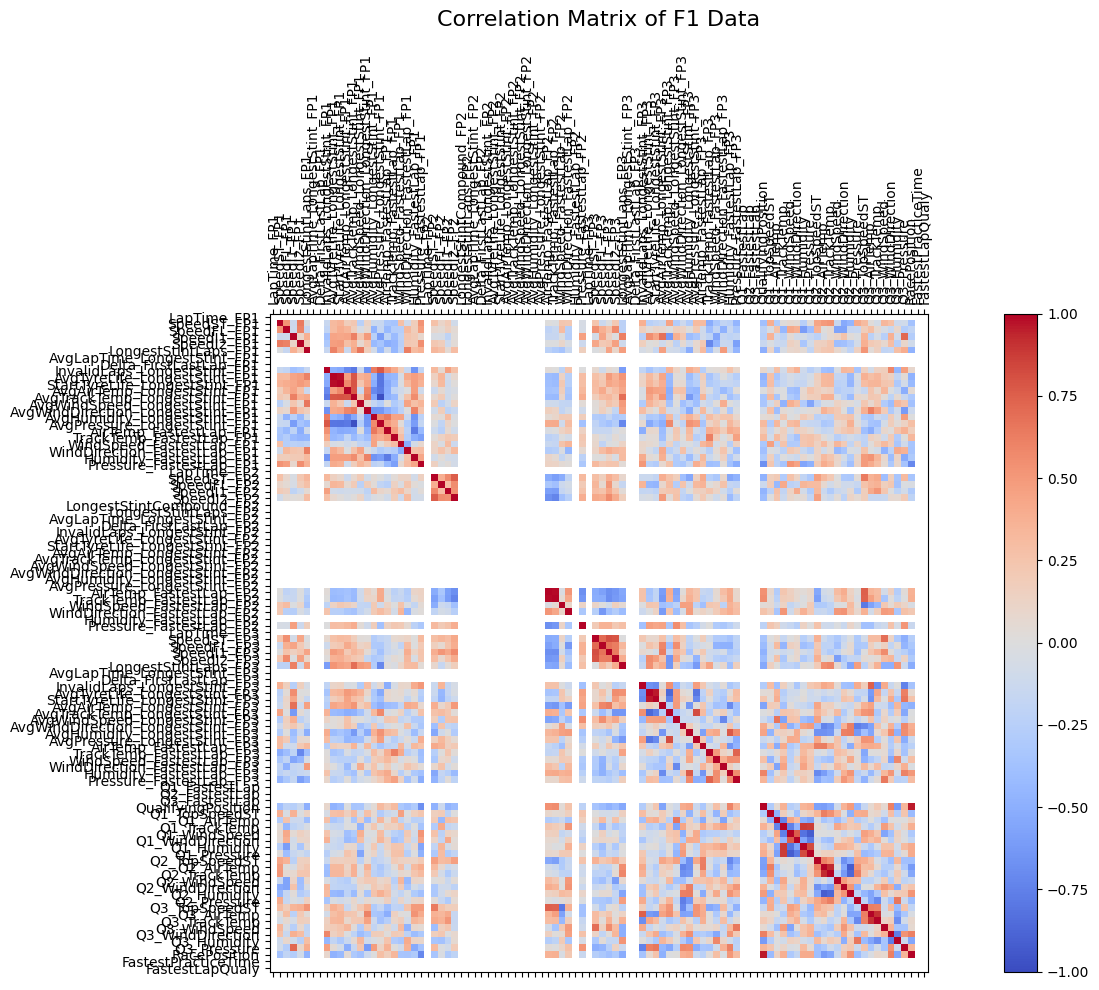

In [36]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
corr['RacePosition'].sort_values(ascending=True)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

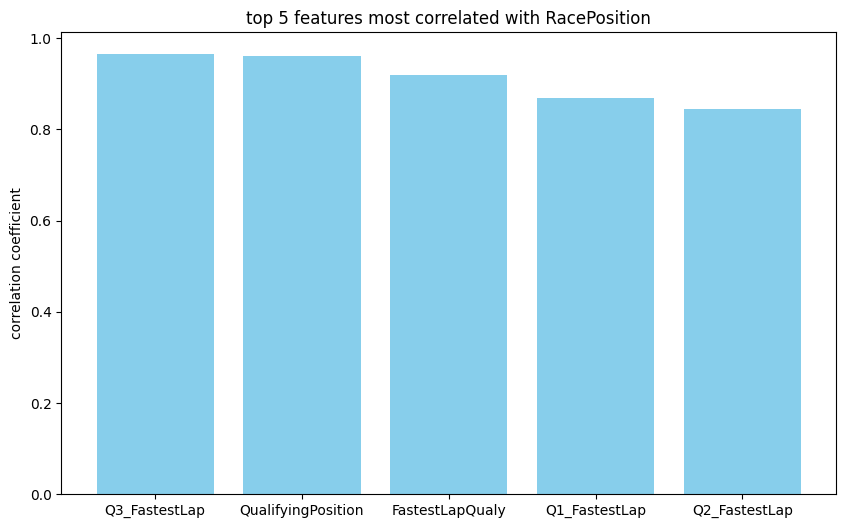

In [ ]:
# most correlated features with RacePosition
corr_race = corr["RacePosition"]
corr_race = corr_race.drop("RacePosition")
sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index
plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("correlation coefficient")
plt.title("top 5 features most correlated with RacePosition")
plt.show()


In [ ]:
# tried keeping only the stronger correlation values 
# there are so many values in the original matrix that it gets confusing
corr = df.corr(numeric_only=True)
threshold = 0.5
filtered_corr = corr.where(corr.abs() > threshold)
print(filtered_corr)


                     LapTime_FP1  SpeedST_FP1  SpeedFL_FP1  SpeedI1_FP1  \
LapTime_FP1             1.000000    -0.625831          NaN          NaN   
SpeedST_FP1            -0.625831     1.000000     0.518997          NaN   
SpeedFL_FP1                  NaN     0.518997     1.000000          NaN   
SpeedI1_FP1                  NaN          NaN          NaN     1.000000   
SpeedI2_FP1                  NaN     0.640362     0.603687          NaN   
...                          ...          ...          ...          ...   
Q3_Humidity                  NaN          NaN          NaN          NaN   
Q3_Pressure                  NaN          NaN          NaN     0.715678   
RacePosition            0.711486          NaN          NaN          NaN   
FastestPracticeTime     0.706366          NaN          NaN          NaN   
FastestLapQualy         0.686800          NaN          NaN          NaN   

                     SpeedI2_FP1  LongestStintLaps_FP1  \
LapTime_FP1                  NaN         